In [1]:
%load_ext autoreload
%autoreload 2

In [5]:
import math
from junctionart.roundabout.encodingGFN.gflownet.gflownet import GFlowNet
from junctionart.roundabout.encodingGFN.policy import ForwardPolicy, BackwardPolicy
from junctionart.roundabout.encodingGFN.setGenerationEnv import SetGenerationEnv
from junctionart.roundabout.encodingGFN.gflownet.utils import trajectory_balance_loss
from torch.optim import Adam
from tqdm import tqdm
import torch 

size =4
nActions = 30
losses = []
rewards = []

flows = []
threePoints = [
            {"x": 80, "y": 20, "heading": math.radians(30),'leftLane': 1, 'rightLane': 1, 'medianType': None, 'skipEndpoint': None},
            {"x": 210, "y": 20, "heading": math.radians(145),'leftLane': 1, 'rightLane': 1, 'medianType': None, 'skipEndpoint': None},
            # {"x": 120, "y": 110, "heading": math.radians(280),'leftLane': 2, 'rightLane': 1, 'medianType': None, 'skipEndpoint': None},
        ]
# threePoints = [
#             {"x": 210, "y": 157, "heading": -2.36416,'leftLane': 1, 'rightLane': 1, 'medianType': None, 'skipEndpoint': None},
#             {'x': 155.02849730584407, 'y': 178.7354878365183, 'heading': -0.9302956737514702, 'leftLane': 1, 'rightLane': 1, 'medianType': None, 'skipEndpoint': None}, 
#             {'x': 178.40679343554933, 'y': 103.36710224137906, 'heading': 2.5252602167413457, 'leftLane': 1, 'rightLane': 1, 'medianType': None, 'skipEndpoint': None}
# ]

# threePoints = [{'x': 233.09333228520728, 'y': 79.46825665874442, 'heading': -3.067898370815696, 'leftLane': 1, 'rightLane': 1, 'medianType': None, 'skipEndpoint': None},
#                {'x': 185.53174334125558, 'y': 110.09333228520728, 'heading': -1.4447421664609699, 'leftLane': 1, 'rightLane': 1, 'medianType': None, 'skipEndpoint': None}, 
#                {'x': 202.29515844326139, 'y': 31.869572626903377, 'heading': 1.95422416249225, 'leftLane': 1, 'rightLane': 1, 'medianType': None, 'skipEndpoint': None}, 
#                {'x': 231.47132341685855, 'y': 57.00357469247282, 'heading': 3.15063609264735, 'leftLane': 1, 'rightLane': 1, 'medianType': None, 'skipEndpoint': None}
# ]

# threePoints should not really be a part of setEnv. TO-DO: fix that later
setEnv = SetGenerationEnv(size, nActions, threePoints)

def train(batch_size, num_epochs):
    forward_policy = ForwardPolicy(setEnv.state_dim, hidden_dim=128, num_actions=setEnv.num_actions)
    backward_policy = BackwardPolicy(setEnv.state_dim, num_actions=setEnv.num_actions)
    
    model = GFlowNet(forward_policy, backward_policy, setEnv)

    opt = Adam([
        {"params": model.forward_policy.parameters()},
        {"params": model.total_flow, "lr": 5e-2},
    ],
    lr=5e-5)
    
    for i in tqdm(range(num_epochs)):
        s0 = torch.zeros(batch_size, size).float()
   
        s, log, traj_length = model.sample_states(s0, return_log=True)
    

        loss = trajectory_balance_loss(log.total_flow,
                                       log.rewards,
                                       log.fwd_probs,
                                       log.back_probs)

        
        flows.append(model.total_flow.item())
        rewards.append(log.rewards.mean())
        losses.append(loss.item())
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1e-2)
        opt.step()
        opt.zero_grad()
        if i % 10 == 0: p.set_description(f"{loss.item():.3f} T.L : {traj_length}")

    return model, losses, rewards, flows

batch_size = 128
num_epochs = 1000

model, losses, rewards, flows = train(batch_size, num_epochs)

0.406 T.L : 5: 100%|███████████████████████| 1000/1000 [03:25<00:00,  4.86it/s]


Text(0.5, 0.98, 'Size = 4, Action = 30, Num_epchs = 1000, Bcz_size = 128')

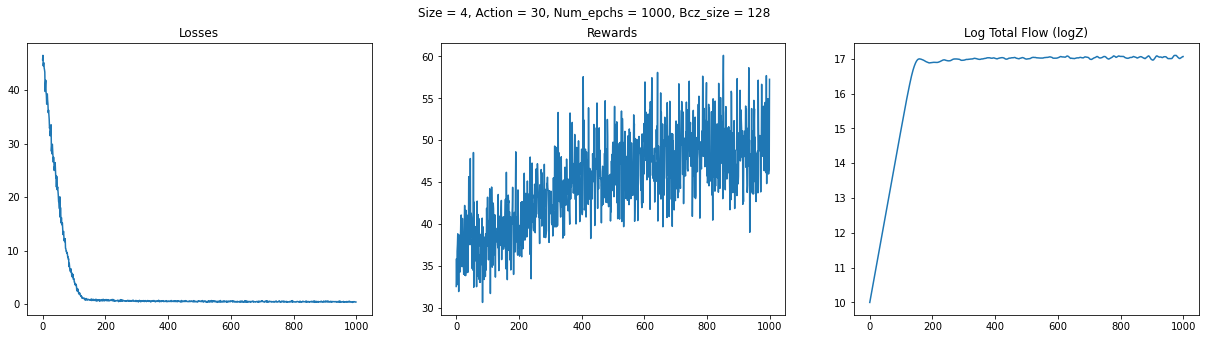

In [6]:
import matplotlib.pyplot as plt
_, ax = plt.subplots(1, 3, figsize=(21, 5))
ax[0].plot(losses)
ax[0].set_title("Losses")
ax[1].plot(rewards)
ax[1].set_title("Rewards")
ax[2].plot(flows)
ax[2].set_title("Log Total Flow (logZ)")


plt.suptitle(f"Size = {size}, Action = {nActions}, Num_epchs = {num_epochs}, Bcz_size = {batch_size}")
# plt.savefig("figs/result30.png")

In [354]:
trainedDict = setEnv.encodingToReward.copy()


In [355]:
a = 0
modes = []
for _ in trainedDict:
    if a < trainedDict[_]:
        a = trainedDict[_]
        
print(a)

for _ in trainedDict:
    if a == trainedDict[_]:
        modes.append(ast.literal_eval(_))
        
print(len(modes))
# print(len(trainedDict))

12.5
273


100%|████████████████████████████████████████████| 1/1 [00:00<00:00,  1.92it/s]


torch.Size([100000, 4])
tensor([[13., 15., 10.,  4.],
        [21., 27.,  1., 26.],
        [25.,  2., 24., 12.],
        [17.,  2., 11., 21.],
        [24., 16., 21.,  9.]])


100%|██████████████████████████████| 100000/100000 [00:00<00:00, 514159.70it/s]


Text(0.5, 0.98, 'Size = 4, Action = 30, Total Samples = 100000')

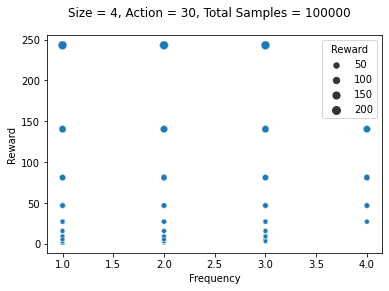

In [7]:
nIter = 1
nBatch = 10**5
terminalStates = []
for i in tqdm(range(nIter)):
    s0 = torch.zeros(nBatch, size).float()
    s, traj_length = model.sample_states(s0, return_log=False)
    terminalStates.append(s)
    
s = torch.concat(terminalStates)
print(s.shape)
print(s[:5])
import seaborn as sns
import pandas as pd


statesForPlot = setEnv.getStateForm(s).long().tolist()
rewardsForPlot = setEnv.reward(s, showProgress=True).tolist()

cnts = []
cnt = 0

stateDict = {}
for i in tqdm(range(len(statesForPlot))):
    state = str(statesForPlot[i])
    if state in stateDict:
        reward, freq = stateDict[state]
        stateDict[state] = (reward, freq + 1)
    else:
        stateDict[state] = (rewardsForPlot[i], 1)
        if rewardsForPlot[i] >= 800000:
            cnt += 1
    cnts.append(cnt)        
    

allRewards = []
freqs = []
for _ in stateDict:
    reward, freq = stateDict[_]
    allRewards.append(reward)
    freqs.append(freq)

# plt.xlim(0, 150)

sns.scatterplot(data=pd.DataFrame({'Frequency':freqs, 'Reward':allRewards}), x='Frequency', y='Reward', size='Reward')
plt.suptitle(f"Size = {size}, Action = {nActions}, Total Samples = {nIter * nBatch}")
# plt.savefig("figs/distribution30.png")

Text(0, 0.5, 'Number of Modes Discovered')

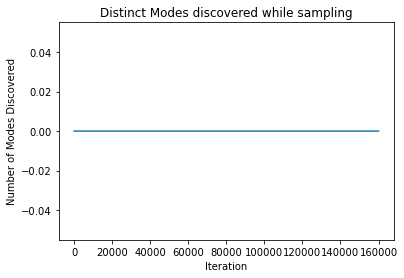

In [31]:
plt.plot(cnts)
plt.title("Distinct Modes discovered while sampling")
plt.xlabel("Iteration")
plt.ylabel("Number of Modes Discovered")

In [362]:
import ast
modesInSampleNotTraining = []
for _ in stateDict:
    reward, freq = stateDict[_]
    if reward >= 800000 and _ not in trainedDict:
        # print(reward, _, freq)
        modesInSampleNotTraining.append(ast.literal_eval(_))
        
print(f"Total Number of Modes : {len(modesInSampleNotTraining)}")

modesInTrainingNotSample = []

for _ in trainedDict:
    reward = trainedDict[_]
    if reward >= 12.5 and _ not in stateDict:
        modesInTrainingNotSample.append(ast.literal_eval(_))
        
print(f"Total Number of Modes : {len(modesInTrainingNotSample)}")

Total Number of Modes : 98
Total Number of Modes : 271


In [9]:
import ast

maxReward = 0
modes = []
rewardWithConfig = []
for _ in stateDict:
    reward, freq = stateDict[_]
    rewardWithConfig.append((reward, _))
    if reward > maxReward:
        maxReward = reward

rewardWithConfig.sort(key = lambda x : x[0], reverse=True)

for reward, config in rewardWithConfig[:500]: # top-500 samples
    modes.append(ast.literal_eval(config))
    
for mode in modes:
    for i, _ in enumerate(mode):
        mode[i] -= 1
        
print("Modes ", len(modes))
print("max reward ", maxReward)

Modes  500
max reward  243.0


In [12]:
from junctionart.roundabout.encodingGFN.RoundaboutLaneEncodingEnv import RoundaboutLaneEncodingEnv

s0 = torch.zeros(1, size).float()
s, traj_length = model.sample_states(s0, return_log=False)


env = RoundaboutLaneEncodingEnv()
maxR = 0
actualModes = []
for i in tqdm(range(len(modes))):
    env.generateWithRoadDefinition(
        roadDefinition=threePoints,
        outgoingLanesMerge=False,
        nSegments=nActions,
        laneToCircularId=modes[i]
    )

    if env.getRoundabout().getReward() >= 7.5:
        actualModes.append(modes[i])
print("Valid Roundabouts found : ", len(actualModes))

100%|████████████████████████████████████████| 500/500 [01:55<00:00,  4.33it/s]

Valid Roundabouts found :  238


/Volumes/Zarif/myStuff/research/summarResearch/esmini_mac/bin/odrplot /Volumes/Zarif/myStuff/research/summarResearch/esmini_mac/bin/pythonroad.xodr


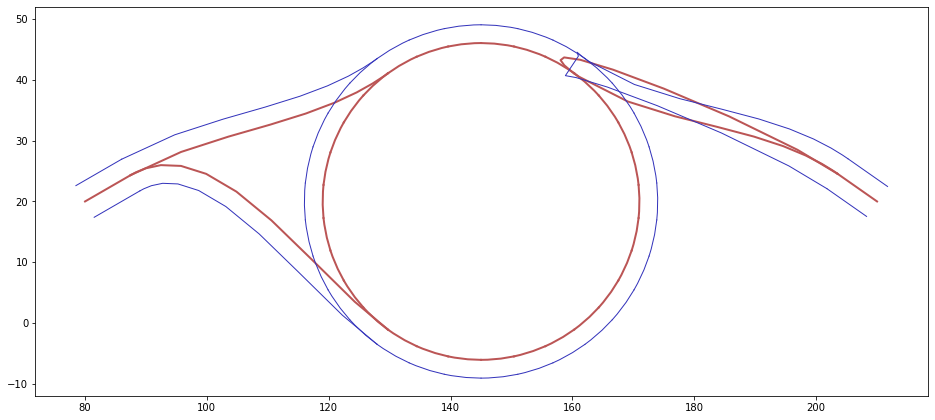

7.5
/Volumes/Zarif/myStuff/research/summarResearch/esmini_mac/bin/odrplot /Volumes/Zarif/myStuff/research/summarResearch/esmini_mac/bin/pythonroad.xodr


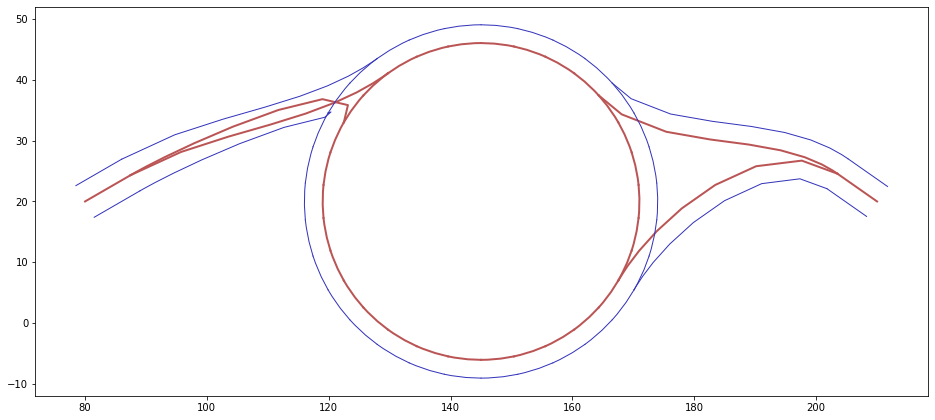

7.5
/Volumes/Zarif/myStuff/research/summarResearch/esmini_mac/bin/odrplot /Volumes/Zarif/myStuff/research/summarResearch/esmini_mac/bin/pythonroad.xodr


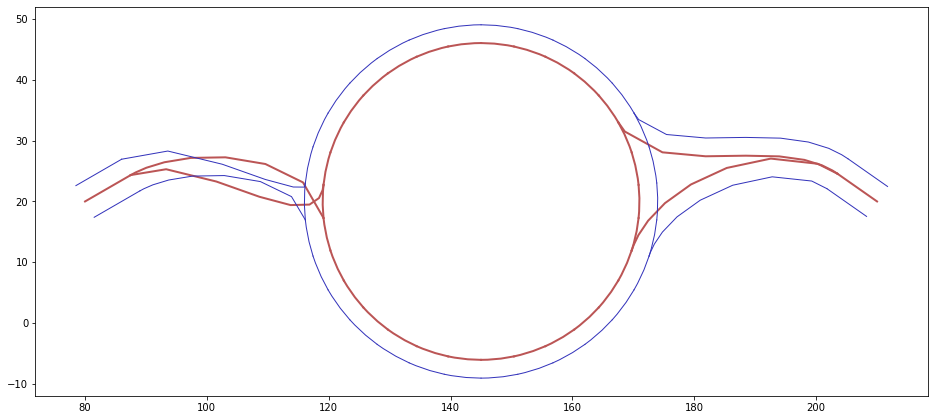

7.5
/Volumes/Zarif/myStuff/research/summarResearch/esmini_mac/bin/odrplot /Volumes/Zarif/myStuff/research/summarResearch/esmini_mac/bin/pythonroad.xodr


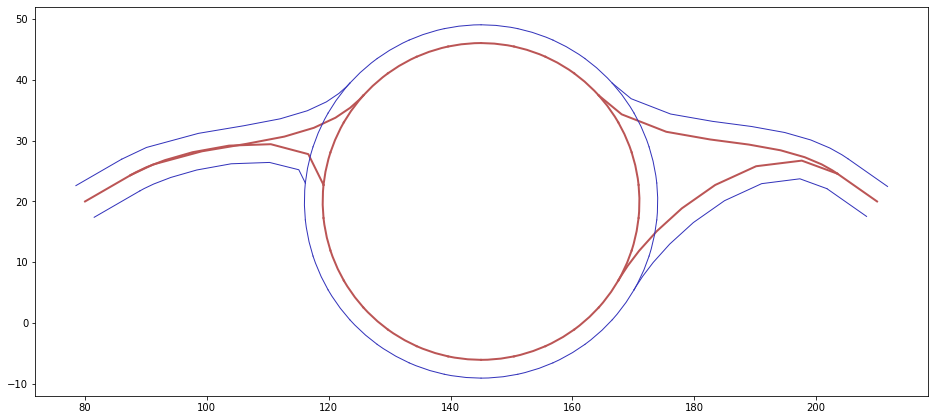

7.5
/Volumes/Zarif/myStuff/research/summarResearch/esmini_mac/bin/odrplot /Volumes/Zarif/myStuff/research/summarResearch/esmini_mac/bin/pythonroad.xodr


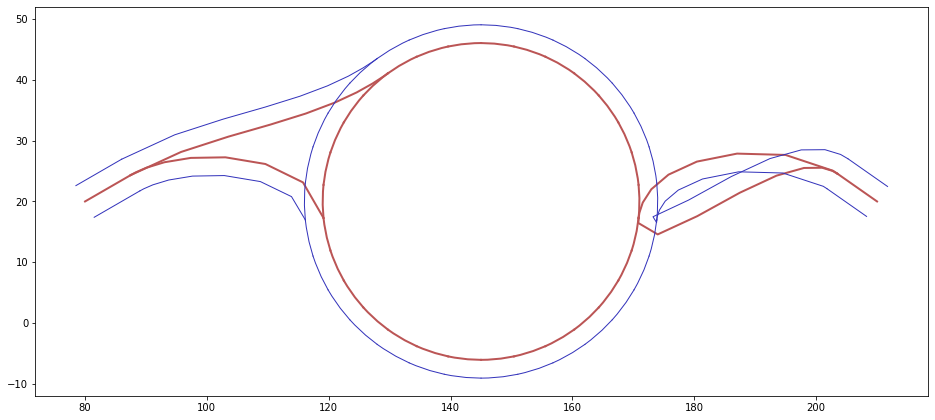

7.5
/Volumes/Zarif/myStuff/research/summarResearch/esmini_mac/bin/odrplot /Volumes/Zarif/myStuff/research/summarResearch/esmini_mac/bin/pythonroad.xodr


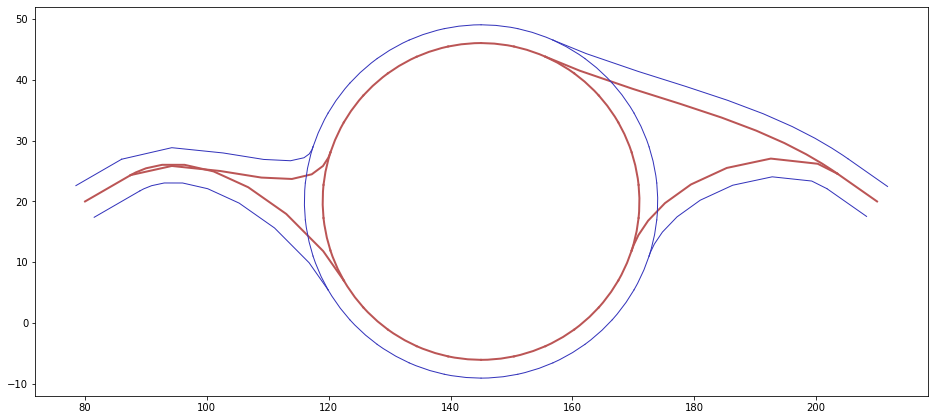

7.5
/Volumes/Zarif/myStuff/research/summarResearch/esmini_mac/bin/odrplot /Volumes/Zarif/myStuff/research/summarResearch/esmini_mac/bin/pythonroad.xodr


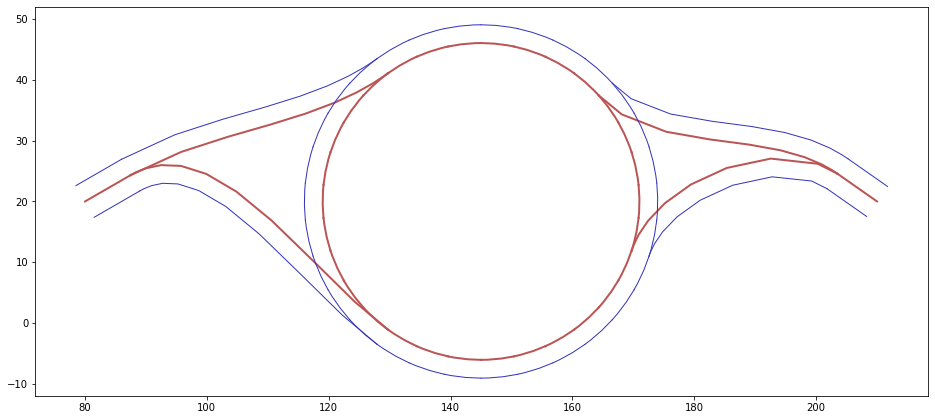

8.0
/Volumes/Zarif/myStuff/research/summarResearch/esmini_mac/bin/odrplot /Volumes/Zarif/myStuff/research/summarResearch/esmini_mac/bin/pythonroad.xodr


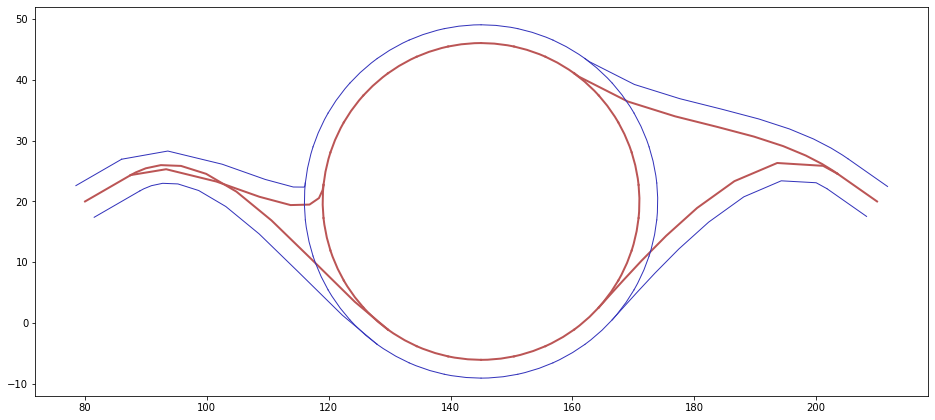

7.5
/Volumes/Zarif/myStuff/research/summarResearch/esmini_mac/bin/odrplot /Volumes/Zarif/myStuff/research/summarResearch/esmini_mac/bin/pythonroad.xodr


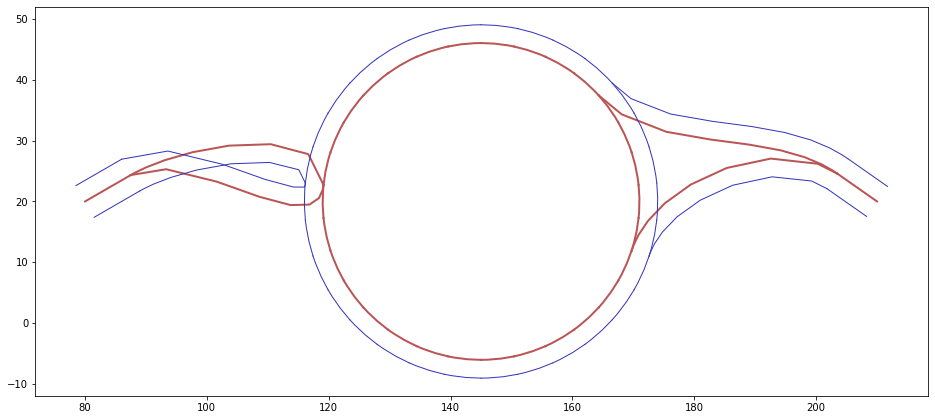

7.5
/Volumes/Zarif/myStuff/research/summarResearch/esmini_mac/bin/odrplot /Volumes/Zarif/myStuff/research/summarResearch/esmini_mac/bin/pythonroad.xodr


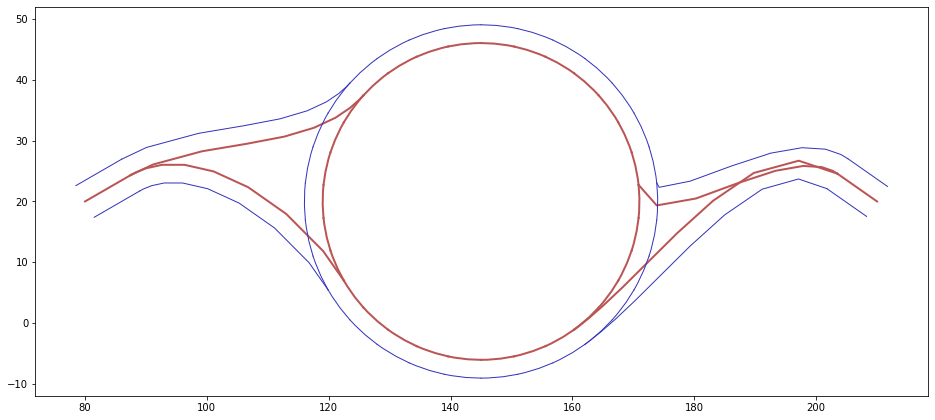

7.5


In [13]:
env = RoundaboutLaneEncodingEnv()
roundabouts = []
for mode in actualModes[:10]:
    env.generateWithRoadDefinition(
        roadDefinition=threePoints,
        outgoingLanesMerge=False,
        nSegments=nActions,
        laneToCircularId=mode
    )
    roundabouts.append(env.getRoundabout())
    env.getRoundabout().showRoundabout()
    print(env.getRoundabout().getReward())

In [63]:
from junctionart.roundabout.RewardUtil import RewardUtil
import numpy as np




In [75]:
RewardUtil.getDistance(roundabouts[0], roundabouts[1], nPoints = 10)

20.92045030178786

/Volumes/Zarif/myStuff/research/summarResearch/esmini_mac/bin/odrplot /Volumes/Zarif/myStuff/research/summarResearch/esmini_mac/bin/pythonroad.xodr


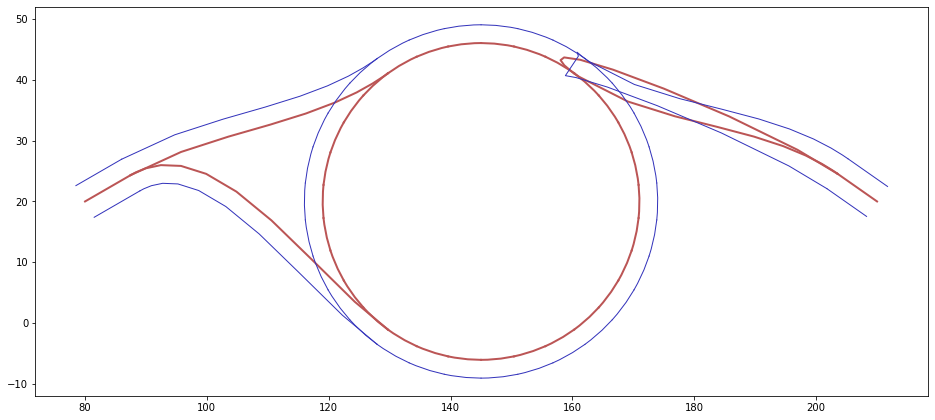

In [65]:
roundabouts[0].showRoundabout()

/Volumes/Zarif/myStuff/research/summarResearch/esmini_mac/bin/odrplot /Volumes/Zarif/myStuff/research/summarResearch/esmini_mac/bin/pythonroad.xodr


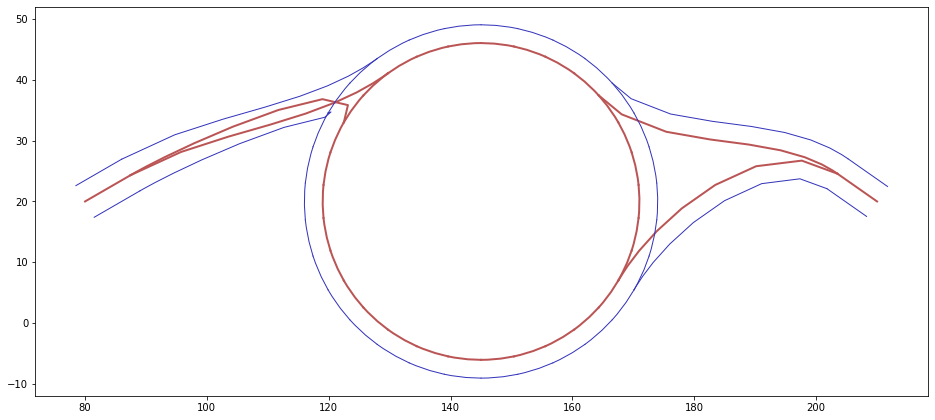

In [53]:
roundabouts[1].showRoundabout()